## CIFAR10 with Tensorflow

This code is written for CIFAR10 using Tensorflow(1.0.1). It achieves an accuracy of 83% after 20 Epochs. 

The model is as follow: <br>
 <br>
Convolution [3x3] 16 filters <br>
Convolution [3x3] 32 filters <br>
Pool [2x2] <br>
Dropout(0.8) <br>

Convolution [3x3] 64 filters <br>
Convolution [3x3] 128 filters <br>
Pool [2x2] <br>
Dropout(0.7) <br>

Convolution [3x3] 128 filters <br>
Convolution [3x3] 256 filters <br>
Flatten <br>
Batch normalisation <br>
Dropout(0.5) <br>
 <br>
All activations are ReLu <br>
Default optimiser is Adam and you can change it to SGD or Nesterov

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
from tqdm import tqdm
import pylab as pl
from IPython import display
from imgaug import augmenters as iaa
import time

In [24]:
data_path = "data/"

In [25]:
def load_CIFAR_batch(filename):
    try:
       with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='bytes')
            X = datadict[b'data']
            Y = datadict[b'labels']
            X = (X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float"))*-1
            Y = np.array(Y)
            return X,Y
    except EOFError:
        return {}

In [26]:
def load_data(path):
    xs = []
    ys = []
    for i in range(1,6):
        f = os.path.join(path, 'data_batch_%d' %( i, ) )
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    X_tr = np.concatenate(xs)
    Y_tr = np.concatenate(ys)
    del X, Y
    X_te , Y_te = load_CIFAR_batch(os.path.join(path, 'test_batch'))
    return X_tr, Y_tr, X_te, Y_te

In [27]:
X_tr, Y_tr, X_te, Y_te = tqdm(load_data(data_path))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


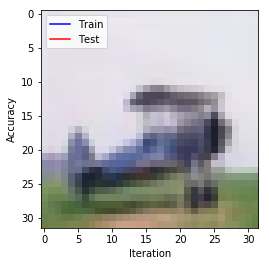

In [28]:
def shuffleData(X_tr, Y_tr):
    shuffle_indices = np.random.permutation(Y_tr.shape[0])
    X_tr = X_tr[shuffle_indices,:,:,:]
    Y_tr = Y_tr[shuffle_indices]
    return X_tr, Y_tr

plt.imshow(X_tr[9800])
plt.show()

In [29]:
def augmentor(images,labels):
    
    aug_images =[]
    for image in tqdm(images):
        aug_images.append(image)
        
        # rotater =iaa.Affine(rotate=(-45, 45)) #not working. Color gets distorted
        # images = rotater.augment_image(image)

        # croper = iaa.Crop(percent=(0.2, 0.1)) #not working. Color gets distorted
        # images = croper.augment_image(image)

        flipper = iaa.Fliplr(1.0) # always horizontally flip each input image
        aug_images.append(flipper.augment_image(image)) 

        vflipper = iaa.Flipud(1.0) # vertically flip each input image with 100% probability
        aug_images.append(vflipper.augment_image(image)) 

        translater1 = iaa.Affine(translate_px={"x": -5}) # move each input image by 5px to the left
        aug_images.append(translater1.augment_image(image)) 

        translater2 = iaa.Affine(translate_px={"x": 5}) # move each input image by 5px to the right
        aug_images.append(translater2.augment_image(image))

        translater3 = iaa.Affine(translate_px={"y": -5}) # move each input image by 5px down
        aug_images.append(translater3.augment_image(image)) 

        translater4 = iaa.Affine(translate_px={"y": 5}) # move each input image by 5px up
        aug_images.append(translater4.augment_image(X_tr[9800]))
        
    aug_labels=[]
    for label in labels:
        aug_labels.extend([label]*7)
    
    print('Augmentation complete')
    return np.array(aug_images),np.array(aug_labels)
    

# X_tr, Y_tr = augmentor(X_tr, Y_tr)

In [30]:
print(X_tr.shape)
print(Y_tr.shape)

(50000, 32, 32, 3)
(50000,)


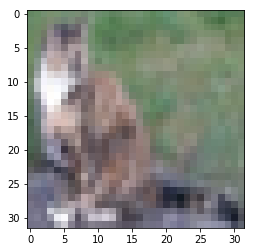

In [31]:
X_tr, Y_tr = shuffleData(X_tr, Y_tr)
#Checking if data looks okay after randomly shuffling
plt.imshow(X_tr[9800])
plt.show()

In [32]:
#Normalization
X_tr -= np.mean(X_tr, axis=0)
X_tr /= np.std(X_tr, axis=0) 

X_te -= np.mean(X_te, axis=0)
X_te /= np.std(X_te, axis=0) 

In [33]:
training_labels = np.zeros((len(Y_tr),10))
testing_labels = np.zeros((len(Y_te),10))
training_labels[np.arange(len(Y_tr)), Y_tr] = 1
testing_labels[np.arange(len(Y_te)), Y_te] = 1
print (Y_tr[5:8])
print(training_labels[5:8])
print(training_labels.shape)

[2 5 6]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
(50000, 10)


In [39]:
#TENSORFLOW MODEL PARAMETERS

image_size = 32
num_labels = 10
num_imgs = 50000
input_channels = 3
output_nodes = 10
data_length = X_tr.shape[0]
batch_size = 50

channels_K = 8 # First convolutional layer depth
channels_L = 16 # Second convolutional layer depth
channels_M = 32 # Third convolutional layer depth
channels_N = 64 # Fourth convolutional layer depth
channels_O = 128 # Fifth convolutional layer depth
channels_P = 256 # Fifth convolutional layer depth
channels_Q = 200 # Fully connected layer nodes

stride_K = 1 
stride_L = 1
pooling1 = 2
stride_M = 1 
stride_N = 1
pooling2 = 2
stride_O = 1 
stride_P = 1 

patch_K = 3
patch_L = 3
patch_M = 3
patch_N = 3
patch_O = 3
patch_P = 3
patch_Q = int(image_size/(pooling1*pooling2*stride_K*stride_L*stride_M*stride_N*stride_O*stride_P))

pkeep_pool1_train, pkeep_pool2_train, pkeep_fc_train = 0.9, 0.7, 0.5 # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.7 at training time
pkeep_pool1_test, pkeep_pool2_test, pkeep_fc_test= 1.0, 1.0, 1.0
num_steps = 20000

lr_start = 0.001 
lr_start_SGD = 0.001
decay_steps = num_steps
decay_rate = 0.95 # for decaying SGD
momentum = 0.9 #for momentum optimizer

In [40]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [ ]:
#placeholder variables to feed data
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32,[None, image_size, image_size, input_channels])
    Y_ = tf.placeholder(tf.float32,[None, output_nodes])
    testing_data = tf.constant(X_te.astype(np.float32))
    global_step = tf.Variable(0)

    W1 = tf.Variable(tf.truncated_normal([patch_K,patch_K,input_channels,channels_K],stddev=0.1))
    B1 = tf.Variable(tf.ones([channels_K])/10)

    W2 = tf.Variable(tf.truncated_normal([patch_L,patch_L,channels_K,channels_L],stddev=0.1))
    B2 = tf.Variable(tf.ones([channels_L])/10)

    W3 = tf.Variable(tf.truncated_normal([patch_M,patch_M,channels_L,channels_M],stddev=0.1))
    B3 = tf.Variable(tf.ones([channels_M])/10)
    
    W4 = tf.Variable(tf.truncated_normal([patch_N,patch_N,channels_M,channels_N],stddev=0.1))
    B4 = tf.Variable(tf.ones([channels_N])/10)
    
    W5 = tf.Variable(tf.truncated_normal([patch_O,patch_O,channels_N,channels_O],stddev=0.1))
    B5 = tf.Variable(tf.ones([channels_O])/10)
    
    W6 = tf.Variable(tf.truncated_normal([patch_P,patch_P,channels_O,channels_P],stddev=0.1))
    B6 = tf.Variable(tf.ones([channels_P])/10)

    W7 = tf.Variable(tf.truncated_normal([patch_Q*patch_Q*channels_P,channels_Q],stddev=0.1))
    B7 = tf.Variable(tf.ones([channels_Q])/10)

    W8 = tf.Variable(tf.truncated_normal([channels_Q,output_nodes],stddev=0.1))
    B8 = tf.Variable(tf.ones([output_nodes])/10)

    #TENSORFLOW MODEL DEFINITION
    
    def model(data,pkeep_pool1, pkeep_pool2, pkeep_fc):

        Y1 = tf.nn.relu(tf.nn.conv2d(data,W1,strides = [1,stride_K,stride_K,1],padding='SAME') + B1 )
        Y2 = tf.nn.relu(tf.nn.conv2d(Y1,W2,strides = [1,stride_L,stride_L,1],padding='SAME') + B2 )
        pool1 = tf.nn.max_pool(Y2, [1,pooling1,pooling1,1],[1,pooling1,pooling1,1], padding='SAME')
        pool1 = tf.nn.dropout(pool1, pkeep_pool1)
        
        Y3 = tf.nn.relu(tf.nn.conv2d(pool1,W3,strides = [1,stride_M,stride_M,1],padding='SAME') + B3 )
        Y4 = tf.nn.relu(tf.nn.conv2d(Y3,W4,strides = [1,stride_N,stride_N,1],padding='SAME') + B4 )
        pool2 = tf.nn.max_pool(Y4, [1,pooling2,pooling2,1],[1,pooling2,pooling2,1], padding='SAME')
        pool2 = tf.nn.dropout(pool2, pkeep_pool2)
        
        Y5 = tf.nn.relu(tf.nn.conv2d(pool2,W5,strides = [1,stride_O,stride_O,1],padding='SAME') + B5 )
        Y6 = tf.nn.relu(tf.nn.conv2d(Y5,W6,strides = [1,stride_P,stride_P,1],padding='SAME') + B6 )
        
        YY = tf.reshape(Y6,shape=[-1, patch_Q*patch_Q*channels_P])

        Y7 = tf.nn.relu(tf.matmul(YY, W7) + B7)
        
        #batch normalisation
        batch_mean, batch_var = tf.nn.moments(Y7,[0])
        offset = tf.Variable(tf.zeros([channels_Q])) 
        scale = tf.Variable(tf.ones([channels_Q]))
        epsilon = 1e-3  
        
        Y7 = tf.nn.batch_normalization(Y7,batch_mean,batch_var,offset,scale,epsilon)
        
        Y7 = tf.nn.dropout(Y7, pkeep_fc) 
        return (tf.matmul(Y7,W8) + B8)
    
    logits = model(X,pkeep_pool1_train, pkeep_pool2_train, pkeep_fc_train)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y_, logits = logits))
    
    op_method = 'Adam'
    
    if op_method=='Adam':
        print('Using Adam optimiser')
        optimizer = tf.train.AdamOptimizer(lr_start).minimize(loss, global_step=global_step)
        
    if op_method=='Nesterov':
        print('Using Nesterov optimiser')
        optimizer = tf.train.MomentumOptimizer(lr_start,momentum, use_nesterov=True).minimize(loss, global_step=global_step) #trying nestrov
    
    if op_method=='SGD':
        print('Using SGD optimiser')
        learning_rate = tf.train.exponential_decay(lr_start_SGD, global_step,num_steps,decay_rate,staircase=True) # decaying SGD
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
    
    train_predict = tf.nn.softmax(logits)
    test_predict = tf.nn.softmax(model(testing_data,pkeep_pool1_test, pkeep_pool2_test, pkeep_fc_test))
    
    saver=tf.train.Saver(write_version=tf.train.SaverDef.V2)

print('######## Model Ready ########')

Using Adam optimiser
######## Model Ready ########


Minibatch loss at step 9000: 0.362733 | Epoch: 9.0 | Time: 37.1 min
Minibatch accuracy: 90.0%
Last test accuracy: 78.0% at step: 8500 | Change: 2.5


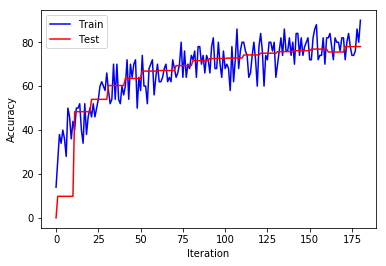

In [ ]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Session Started")
    time_start = time.time()
    
#     try: saver.restore(sess, os.path.join(os.getcwd(), 'Model_variables_pooling.ckpt')) #reads saved checkpoint
#     except: print('No model available')
    
    print('Model_variables read')
    
    train_accuracy_plot, test_accuracy_plot,step_plot = [], [], []
    test_accuracy,last_test_accuracy, change, last_step = 0,0,0,0
        
    for step in range(num_steps+1):
       
        start_index = step*batch_size % (training_labels.shape[0] - batch_size)
        end_index = start_index + batch_size
        batch_data = X_tr[start_index:end_index, : , : , :]
        batch_labels = training_labels[start_index:end_index,:]
        
        fdict = {X:batch_data, Y_:batch_labels}
        _ , l, predictions = sess.run([optimizer, loss, train_predict], feed_dict=fdict)
        
        if step % 50 == 0:
            train_accuracy = accuracy(predictions, batch_labels)
            
            display.clear_output(wait=True)
            print('Minibatch loss at step %d: %g | Epoch: %.1f | Time elapsed: %.1f min' % (step, l, step*batch_size/num_imgs, (time.time() - time_start)/60))
            print('Minibatch accuracy: %.1f%%' %train_accuracy )
            print('Last test accuracy: %.1f%% at step: %s | Last change: %.1f' % (test_accuracy, last_step, change ))

            
            train_accuracy_plot.append(train_accuracy) 
            test_accuracy_plot.append(test_accuracy)
            step_plot.append(step/100)    
            
            pl.clf()
            pl.xlabel('Iteration')
            pl.ylabel('Accuracy')
            pl.plot(train_accuracy_plot, '-b', label='Train')
            pl.plot(test_accuracy_plot, '-r', label='Test')
            pl.legend(loc='upper left')
            display.display(pl.gcf())            
            
        if step % 500 == 0:            
            test_accuracy = accuracy(test_predict.eval(), testing_labels)
            change = test_accuracy - last_test_accuracy 
            last_test_accuracy = test_accuracy
            last_step = step
            
        if step % 2000== 0 and step!=0:
            save_path= saver.save(sess, os.path.join(os.getcwd(), 'Model_variables_pooling.ckpt'))   #creates checkpoint
            print ("Model saved in file: %s \n" %save_path)
            
    print('Iterations complete')